<a href="https://colab.research.google.com/github/chuong1210/.NetMVC-EcommerceApp/blob/main/FoodAI_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Food.AI Training Notebook**
Easy calorie tracking using real-time object detection on Android.

**[GitHub](https://github.com/jonathanyin12/Food.AI)**

### **Instructions**:
* Prior to starting, create a directory in Google Drive called *food_detection*. Add the **[training dataset](https://drive.google.com/file/d/11WC6XPp4kHGN1vEzl_ZRnFla99pxIs33/view)** and **[label_map.pbtxt](https://github.com/jonathanyin12/Food.AI/blob/master/label_map.pbtxt)** to *food_detection*.

* Make sure runtime is set to use GPU acceleration

* After installing the correct version of NumPy, restart the runtime and run all the cells after.




In [ ]:
# Checking gpu
!nvidia-smi

Sun Jun 21 11:57:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Installing Dependencies**

In [ ]:
# IMPORTANT: make sure to restart runtime after running this cell
!pip install numpy==1.17.4

     |████████████████████████████████| 20.0MB 1.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [ ]:
%tensorflow_version 1.x

!git clone --quiet https://github.com/tensorflow/models.git # download training tools

!wget http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz # download model
!tar xvzf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

!git clone --quiet https://github.com/zamblauskas/oidv4-toolkit-tfrecord-generator.git # download tfrecord generator tool

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive pycocotools

TensorFlow 1.x selected.
--2020-06-21 11:58:11--  http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.203.128, 2607:f8b0:400c:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.203.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187925923 (179M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’

ssd_mobilenet_v2_co 100%[===================>] 179.22M   269MB/s    in 0.7s    

2020-06-21 11:58:11 (269 MB/s) - ‘ssd_mobilenet_v2_coco_2018_03_29.tar.gz’ saved [187925923/187925923]

ssd_mobilenet_v2_coco_2018_03_29/checkpoint
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.meta
ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
ssd_mobilenet_v2_coco_2018_03_29/saved_model/saved_model.pb
ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
ssd_mobilenet_v2_coco_2018_03_29/saved_model/
ssd_mobilenet_v2

In [ ]:
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
!python setup.py -q build
!python setup.py -q install

import os
os.environ['PYTHONPATH'] += '/content/models/research/:/content/models/research/slim/'

%cd /content/models/research/slim
!pip install -e .

%cd /content/models/research
!python object_detection/builders/model_builder_test.py

/content/models/research
object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.
zip_safe flag not set; analyzing archive contents...
object_detection.core.__pycache__.preprocessor.cpython-36: module MAY be using inspect.stack
object_detection.utils.__pycache__.autoaugment_utils.cpython-36: module MAY be using inspect.stack
/content/models/research/slim
Obtaining file:///content/models/research/slim
     |████████████████████████████████| 358kB 2.9MB/s 
  Running setup.py develop for slim
/content/models/research


### **Load food dataset and label map from Drive**

In [ ]:
%cd /content/

from google.colab import drive
from zipfile import ZipFile
from shutil import copyfile

drive.mount('/content/gdrive')
copyfile('/content/gdrive/My Drive/food_detection/label_map.pbtxt', 'label_map.pbtxt')

data_path='/content/gdrive/My Drive/food_detection/OIDv4_ToolKit.zip'
with ZipFile(data_path, 'r') as zipObj:
    zipObj.extractall()

/content


### **Convert dataset into TFRecords format**

In [ ]:
!python oidv4-toolkit-tfrecord-generator/generate-tfrecord.py \
    --classes_file=OIDv4_ToolKit/classes.txt \
    --class_descriptions_file=OIDv4_ToolKit/OID/csv_folder/class-descriptions-boxable.csv \
    --annotations_file=OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv \
    --images_dir=OIDv4_ToolKit/OID/Dataset/train \
    --output_file=train.record

!python oidv4-toolkit-tfrecord-generator/generate-tfrecord.py \
    --classes_file=OIDv4_ToolKit/classes.txt \
    --class_descriptions_file=OIDv4_ToolKit/OID/csv_folder/class-descriptions-boxable.csv \
    --annotations_file=OIDv4_ToolKit/OID/csv_folder/validation-annotations-bbox.csv \
    --images_dir=OIDv4_ToolKit/OID/Dataset/validation \
    --output_file=val.record


Classes: {'Bread': 1, 'Pancake': 2, 'Waffle': 3, 'Bagel': 4, 'Muffin': 5, 'Doughnut': 6, 'Hamburger': 7, 'Pizza': 8, 'Sandwich': 9, 'Hot dog': 10, 'French fries': 11, 'Apple': 12, 'Orange': 13, 'Banana': 14, 'Grape': 15}

W0621 12:01:36.732901 140051544106880 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate-tfrecord.py:32: The name tf.gfile.Glob is deprecated. Please use tf.io.gfile.glob instead.

6419 images

W0621 12:01:36.878070 140051544106880 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate-tfrecord.py:37: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.


W0621 12:01:36.909929 140051544106880 module_wrapper.py:139] From oidv4-toolkit-tfrecord-generator/generate-tfrecord.py:40: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

...............................................................................................................................................

### **Edit model configuration files**

In [ ]:
import re

filename = '/content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config'
with open(filename) as f:
    s = f.read()
with open(filename, 'w') as f:
    s = re.sub('90', '15', s) # change number of classes from 90 to 15
    s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/ssd_mobilenet_v2_coco_2018_03_29/model.ckpt', s) # pass location of model checkpoint
    s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100', '/content/train.record', s) # pass location of train tfrecod
    s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record-\?\?\?\?\?-of-00010', '/content/val.record', s) # pass location of validation tfrecord
    s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/label_map.pbtxt', s) # pass location of label map

    f.write(s)

### **Train model**

In [ ]:
!python models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --model_dir=/content/gdrive/My\ Drive/food_detection/model_checkpoints

### **Export model to frozen TensorFlow Lite graph**

In [ ]:
lst = os.listdir('/content/gdrive/My Drive/food_detection/model_checkpoints')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssd_mobilenet_v2_coco.config \
    --trained_checkpoint_prefix=/content/gdrive/My\ Drive/food_detection/model_checkpoints/$last_model \
    --output_directory=/content/gdrive/My\ Drive/food_detection/model_checkpoints/tflite_model \
    --add_postprocessing_op=true

### **Convert the frozen graph to a TFLite model**

In [ ]:
%cd /content/gdrive/My\ Drive/food_detection/model_checkpoints/tflite_model

!tflite_convert \
    --output_file=food_detect.tflite \
    --graph_def_file=tflite_graph.pb \
    --input_arrays=normalized_input_image_tensor \
    --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3'\
    --input_shape=1,300,300,3 \
    --allow_custom_ops

In [1]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
!tar xzvf food-101.tar.gz

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
food-101/images/cannoli/695879.jpg
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/ca

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
# Thay đổi dòng này:
# from keras.utils.np_utils import to_categorical

# Thành dòng này:
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models

%cd content/

%matplotlib inline

[Errno 2] No such file or directory: 'content/'
/content


In [5]:
class_N = {}
N_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    class_N = dict(zip(classes, range(len(classes))))
    N_class = dict(zip(range(len(classes)), classes))
    class_N = {i: j for j, i in N_class.items()}
class_N_sorted = collections.OrderedDict(sorted(class_N.items()))
print(class_N)

# Method to generate directory-file map.
def gen_dir_file_map(path):
    dir_files = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            dir_files[dir_name].append(id + '.jpg')
    return dir_files

# Method to recursively copy a directory.
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

# Train files to ignore.
def ignore_train(d, filenames):
  subdir = d.split('/')[-1]
  train_dir_files = gen_dir_file_map('food-101/meta/train.txt')
  to_ignore = train_dir_files[subdir]
  return to_ignore

# Test files to ignore.
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  test_dir_files = gen_dir_file_map('food-101/meta/test.txt')
  to_ignore = test_dir_files[subdir]
  return to_ignore

# Method to load and resize images.
def load_images(path_to_imgs):
  resize_count = 0

  invalid_count = 0
  all_imgs = []
  all_classes = []

  for i, subdir in enumerate(listdir(path_to_imgs)):
      imgs = listdir(join(path_to_imgs, subdir))
      classN = class_N[subdir]
      for img_name in imgs:
          img_arr = cv2.imread(join(path_to_imgs, subdir, img_name))
          img_arr_rs = img_arr
          img_arr_rs = cv2.resize(img_arr, (200,200),interpolation=cv2.INTER_AREA)
          resize_count += 1
          im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
          all_imgs.append(im_rgb)
          all_classes.append(classN)

  return np.array(all_imgs), np.array(all_classes)

# Method to generate train-test files.
def gen_train_test_split(path_to_imgs = 'food-101/images' , target_path = 'food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=ignore_train)

# Method to load train-test files.
def load_train_test_data(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test


{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [7]:
# Generate train-test files.
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):
    print('train and test folders not already exists.')

    gen_train_test_split()
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)
else:
    print('train and test folders already exists.')
    len_train = len(os.listdir('/content/food-101/train'))
    len_test = len(os.listdir('/content/food-101/test'))
    print(len_train,len_test)

train and test folders already exists.
101 101


In [8]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('food-101/images'))
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

(384, 512, 3)


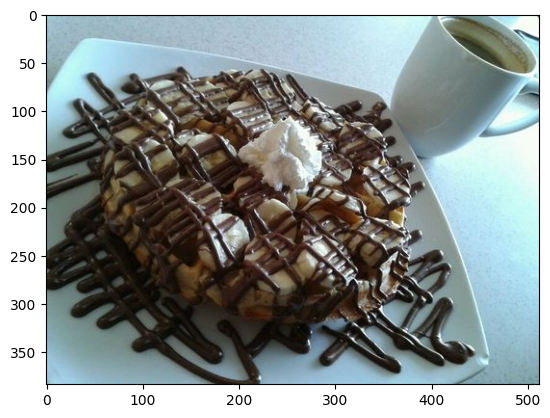

In [9]:
testImg = imread('/content/food-101/test/waffles/1236559.jpg')
print(testImg.shape)
plt.imshow(testImg)

In [ ]:
X_train, y_train, X_test, y_test = load_train_test_data('/content/food-101/train','/content/food-101/test')

In [2]:
from tensorflow.keras.utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
tensorflow.keras.backend.clear_session()

n_classes = 101
batch_size = 16
width, height = 200, 200
train_data = '/content/food-101/train'
test_data = '/content/food-101/test'
train_samples = 75750
test_samples = 25250

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128,activation='relu')(layer)
layer = Dropout(0.2)(layer)

predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit(train_gen, steps_per_epoch= train_samples // batch_size, validation_data= test_gen, validation_steps= test_samples // batch_size, epochs=30, callbacks=[csv_logger, checkpointer])

model.save('model_trained_101class.hdf5')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


ValueError: Argument(s) not recognized: {'lr': 0.0001}